## 1.Environment Setup

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, MinMaxScaler

# Đặt seed để đảm bảo nhất quán giữa các lần chạy
os.environ["PYTHONHASHSEED"] = "42"
np.random.seed(42)
random.seed(42)
print("Seed: 42")

Seed: 42


## 2.Data Processing

In [ ]:
# Tạo thư mục chứa data
!mkdir "../data/"

A subdirectory or file ../data/ already exists.


In [ ]:
# Tải về và lưu vào trong thư mục data
# https://drive.google.com/file/d/16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju/view?usp=sharing
!gdown 16HPyuXWXPptt5g3xvS_kR_wXAfjpR1Ju -O "../data/cleveland.csv"

![Feature Info](..\images\Feature-Info.png)



In [13]:
DATA_PATH = '../data/cleveland.csv'
COLUMNS = ['age','sex','cp','trestbps','chol','fbs','restecg',
           'thalach','exang','oldpeak','slope','ca','thal','target']

raw = pd.read_csv(DATA_PATH, header=None)
raw.columns = COLUMNS

for c in ['age','trestbps','chol','thalach','oldpeak','ca','thal']:
    raw[c] = pd.to_numeric(raw[c], errors='coerce')

raw['target'] = (raw['target'] > 0).astype(int)
print("Shape:", raw.shape)
display(raw.head())
display(raw.isna().sum())

Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64

**Đánh giá:**
- Có 303 dòng dữ liệu, 14 features.
- Có 4 sample NaN ở `ca`, 2 sample NaN ở `thal`

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


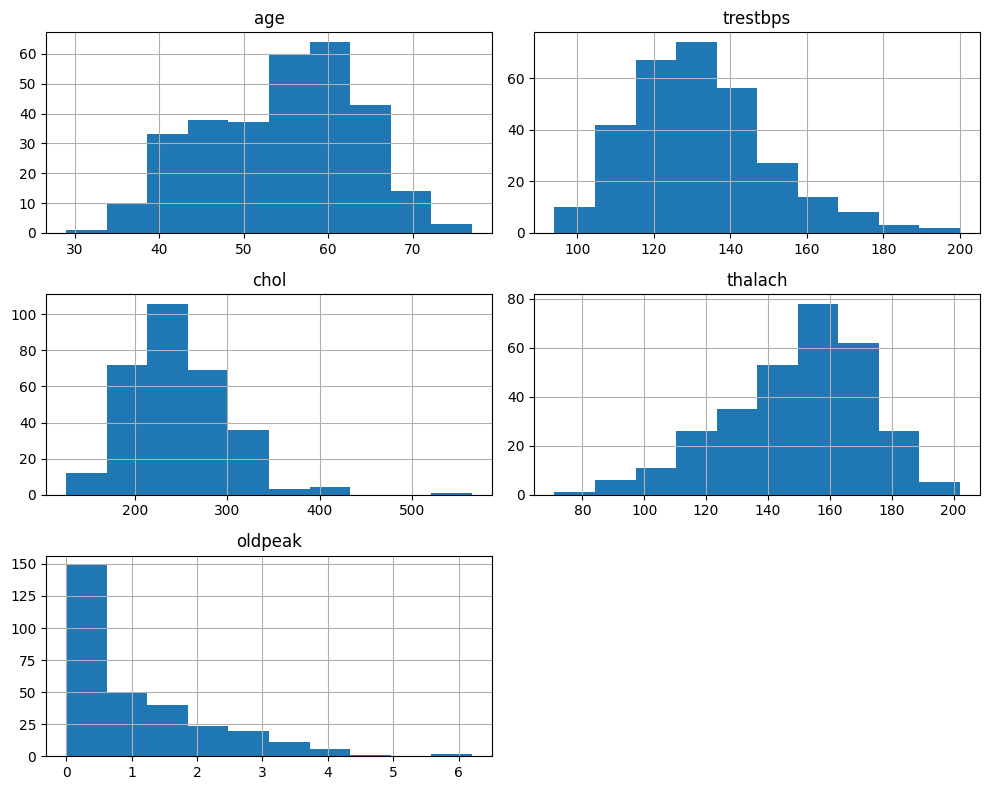

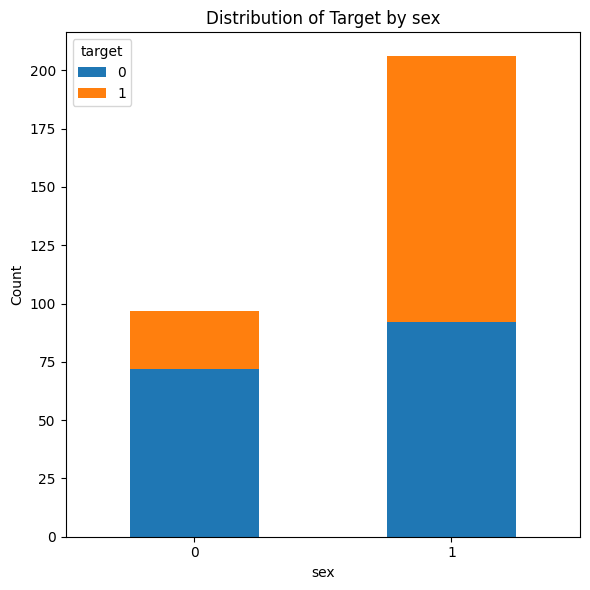

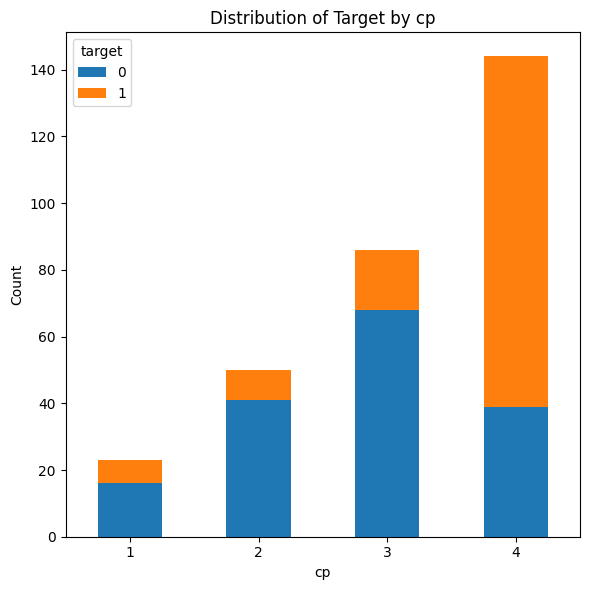

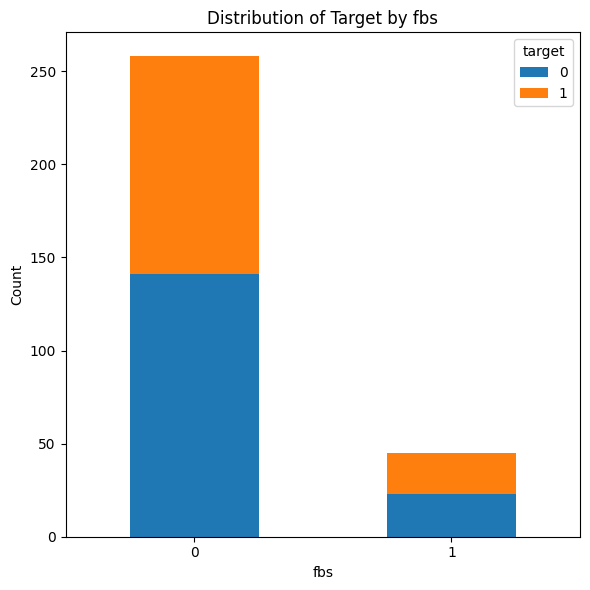

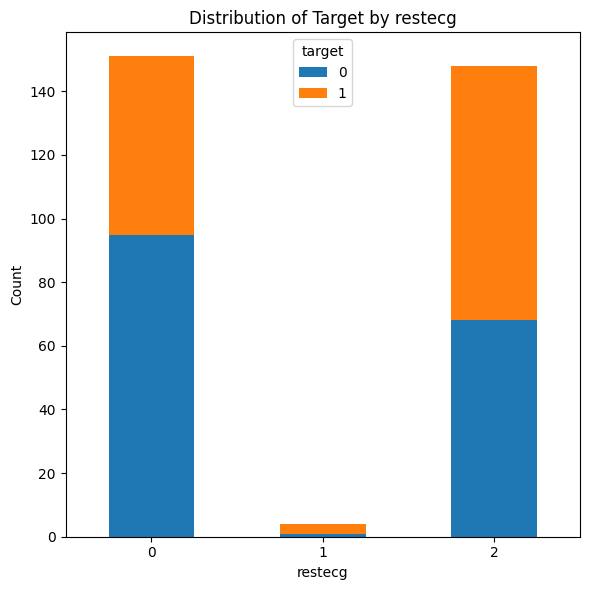

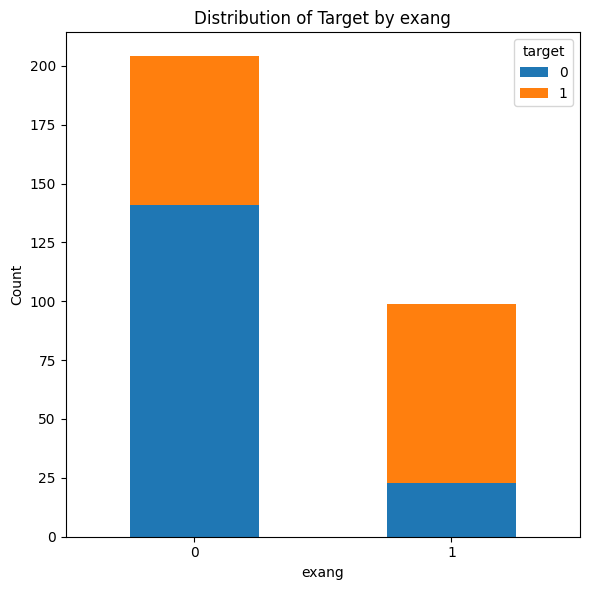

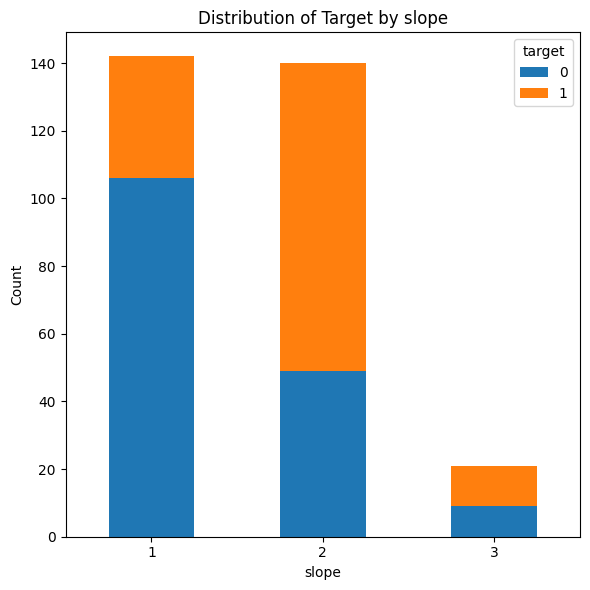

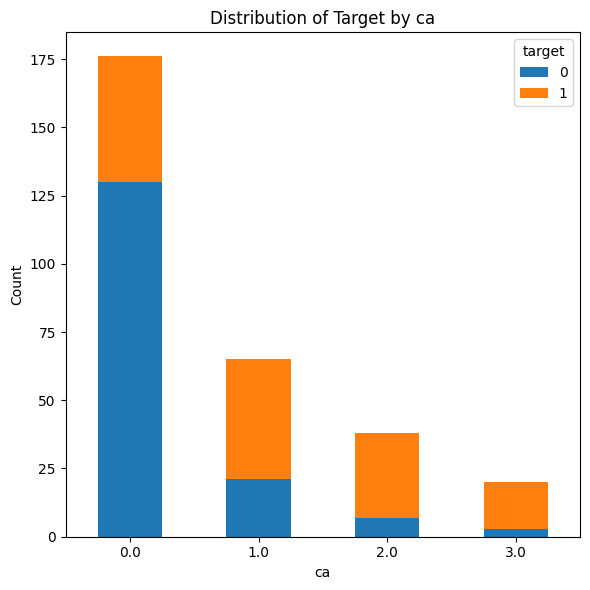

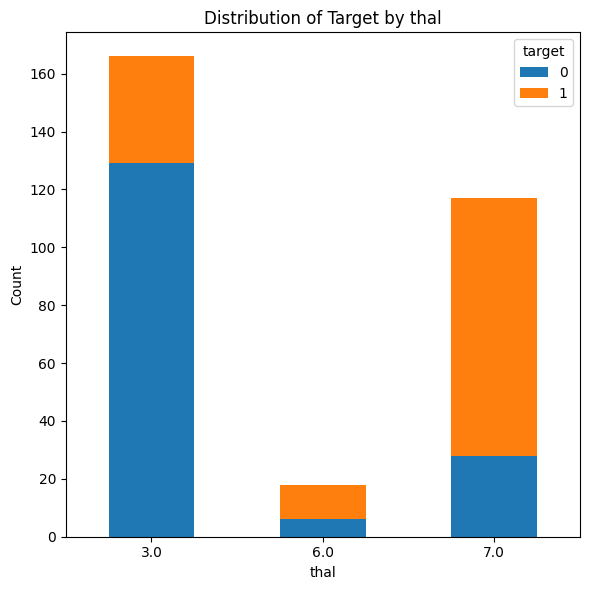

In [14]:
# basic statistic
display(raw.describe())

# Define numerical, categorical columns before plotting
numeric_cols = ['age','trestbps','chol','thalach','oldpeak']
categorical_cols = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

# Plot histograms for numerical columns
raw[numeric_cols].hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

# Plot count plots for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(6, 6))
    raw.groupby([col, 'target']).size().unstack().plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Distribution of Target by {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

**Đánh giá:**

*1) Thống kê & phân phối (histogram các biến số)*
- **age**: tập trung ~45–65, lệch nhẹ về phía trung niên/cao tuổi → phù hợp bối cảnh tim mạch.
- **trestbps** (huyết áp nghỉ): phần lớn 110–150 mmHg; có đuôi phải (một số cao hơn 160).
- **chol** (cholesterol): trung tâm ~200–270 mg/dL; có **outlier khá cao** (≥ 400–500) → nên kiểm tra/winsorize.
- **thalach** (nhịp tim tối đa khi gắng sức): phân phối tương đối “chuông” quanh 140–160 bpm; hiếm giá trị < 100 hoặc > 190.
- **oldpeak** (độ chênh ST do gắng sức): **rất lệch phải** (nhiều 0–1, ít điểm 3–6) → biến có đuôi dài, nhạy với outlier.

=> *Tiền xử lý*  
- Cân nhắc **chuẩn hoá**/scale các biến số (đặc biệt `oldpeak`, `chol`).
- **Winsorize/IQR** cho `chol`, `oldpeak` nếu mô hình tuyến tính/ khoảng cách bị ảnh hưởng bởi outlier.
- Kiểm tra Missings sau parse (đặc biệt `ca`, `thal` có thể có dấu `?` trong bản gốc).

*2) Quan hệ nhãn theo biến phân loại (stacked bar)*
- **sex**: sample **nam (1)** chiếm đa số và có **tỷ lệ bệnh cao hơn** nữ (0).
- **cp** (chest pain type): nhóm **cp=4** có **tỷ lệ bệnh cao**; các nhóm `1–3` thiên về không bệnh hơn. (Lưu ý: bộ Cleveland thường dùng mã 1–4.)
- **fbs** (>120 mg/dL): **tín hiệu yếu/hiếm**, phân bố target gần như cân bằng → ít hữu ích một mình.
- **restecg**: chủ yếu ở mã **0** và **2**; nhóm hiếm **1** rất ít điểm → cẩn trọng khi suy luận (dễ nhiễu).
- **exang** (đau thắt ngực do gắng sức): **exang=1** liên quan **mạnh** đến có bệnh; **exang=0** thiên về không bệnh.
- **slope** (độ dốc ST đỉnh gắng sức): **slope=2** (thường “flat”) có **tỷ lệ bệnh cao**; `slope=1` thấp hơn; `slope=3` ít sample.
- **ca** (số mạch vành lớn): xu hướng **ca càng cao → tỷ lệ bệnh càng cao**. `ca=0` đa phần không bệnh; `1–3` nghiêng về có bệnh.
- **thal**: các mã thường gặp **3 (Normal)**, **6 (Fixed defect)**, **7 (Reversible defect)**. Quan sát thấy **thal=7** gắn với **tỷ lệ bệnh cao**; **thal=3** thiên về không bệnh.

=> *Ý nghĩa*
- Các biến **mạnh**: `cp`, `exang`, `slope`, `ca`, `thal`, `oldpeak`.
- Biến **yếu/hiếm**: `fbs`, `restecg=1` (ít sample) → đóng góp thấp nếu không kết hợp với biến khác.
- Cân nhắc **one-hot** cho `cp`, `slope`, `thal`; giữ `ca` dạng rời rạc/ordinal (với model cây) hoặc one-hot (với tuyến tính).

## 3.Visual Explorations

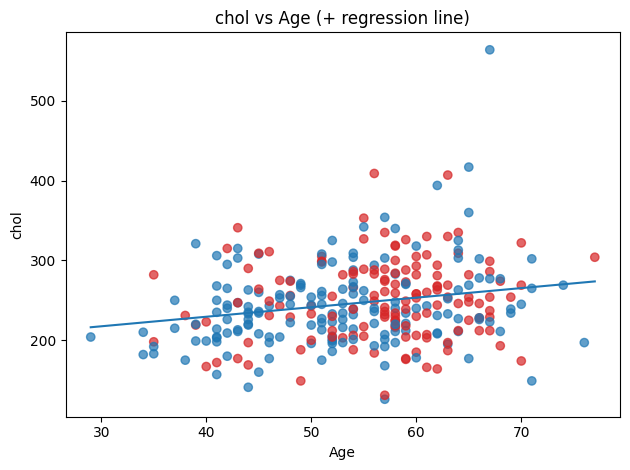

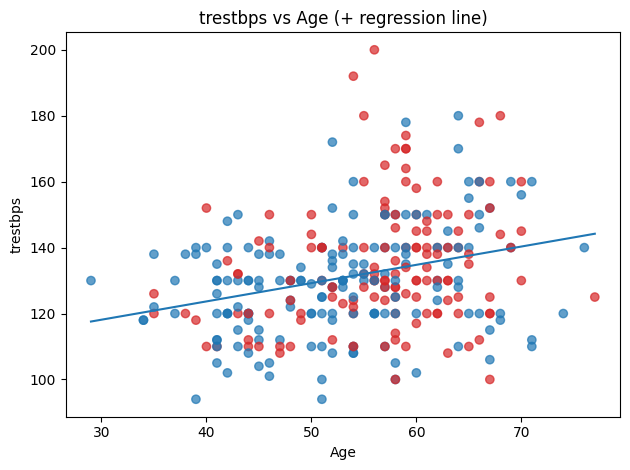

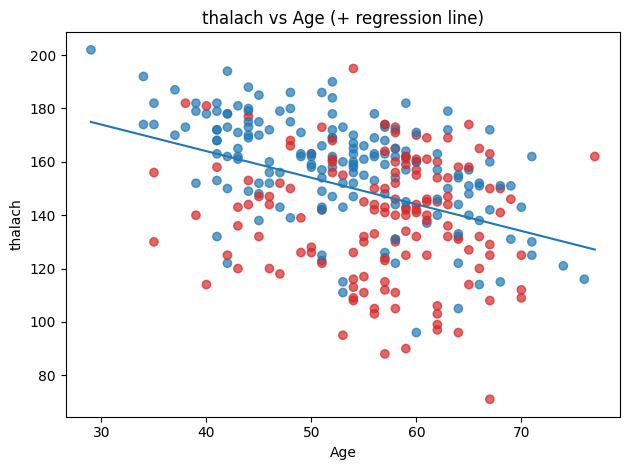

C:\Users\rincl\AppData\Local\Temp\ipykernel_14576\882144554.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


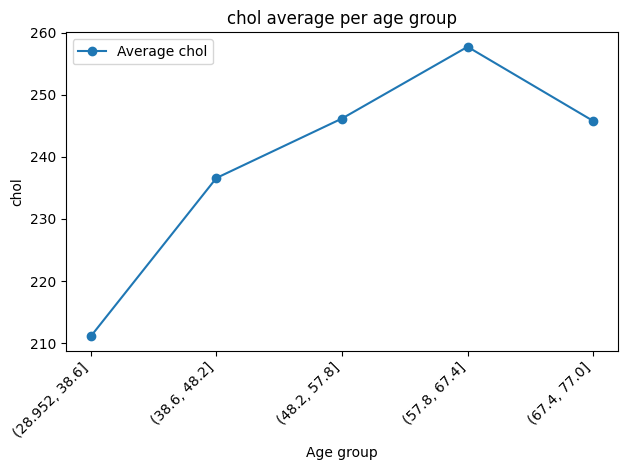

C:\Users\rincl\AppData\Local\Temp\ipykernel_14576\882144554.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


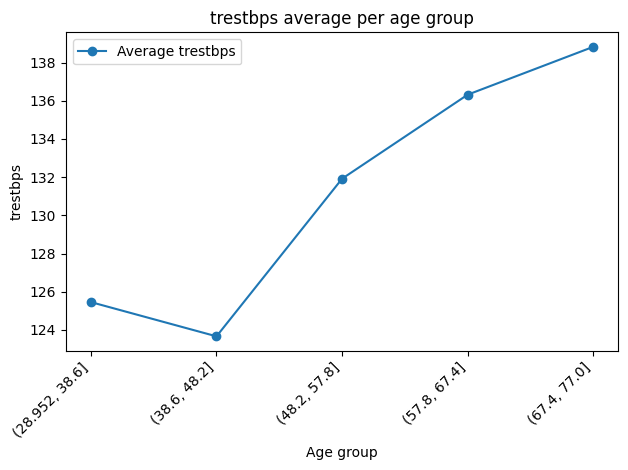

C:\Users\rincl\AppData\Local\Temp\ipykernel_14576\882144554.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


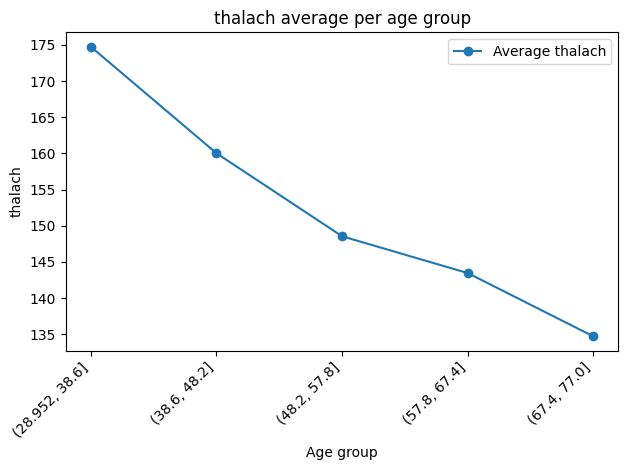

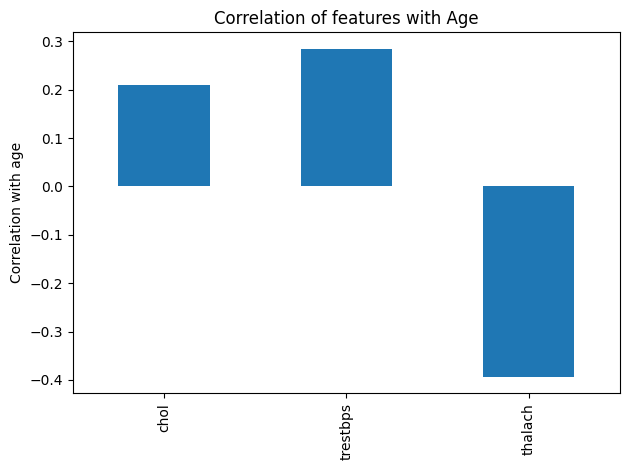

In [15]:
X = raw.drop(columns=['target'])
y = raw['target']

# Colors by target
colors = ['tab:blue' if t==0 else 'tab:red' for t in y]

def scatter_with_regression(x_series, y_series, x_label, y_label, title):
    # Drop NaNs for fitting
    m = x_series.notna() & y_series.notna()
    x = x_series[m].values.reshape(-1, 1)
    yy = y_series[m].values
    # Fit linear regression
    if len(x) > 1:
        model = LinearRegression()
        model.fit(x, yy)
        # Create line
        x_line = np.linspace(x.min(), x.max(), 100).reshape(-1,1)
        y_pred = model.predict(x_line)
    else:
        x_line, y_pred = None, None

    # Plot scatter
    plt.figure()
    plt.scatter(x_series, y_series, c=colors, alpha=0.7)
    plt.xlabel(x_label); plt.ylabel(y_label)
    plt.title(title)

    # Plot regression line
    if x_line is not None:
        plt.plot(x_line.ravel(), y_pred)
    plt.tight_layout()
    plt.show()

# Scatter + regression for selected pairs
if 'age' in X.columns:
    for col in ['chol', 'trestbps', 'thalach']:
        if col in X.columns:
            scatter_with_regression(X['age'], X[col], 'Age', col, f'{col} vs Age (+ regression line)')

# Group means by age bins
if 'age' in X.columns:
    age_bins = pd.cut(X['age'], bins=5)
    for m in ['chol','trestbps','thalach']:
        if m in X.columns:
            plt.figure()
            avg_vals = X.groupby(age_bins)[m].mean()
            plt.plot(range(len(avg_vals)), avg_vals, marker='o', label=f'Average {m}')
            plt.xticks(range(len(avg_vals)), [str(i) for i in avg_vals.index], rotation=45, ha='right')
            plt.xlabel('Age group'); plt.ylabel(m)
            plt.title(f'{m} average per age group')
            plt.legend(); plt.tight_layout(); plt.show()

# Correlation with age
num_df = X[['age','chol','trestbps','thalach']].copy()
corr = num_df.corr(numeric_only=True)['age'].drop('age')
plt.figure()
corr.plot(kind='bar')
plt.ylabel('Correlation with age')
plt.title('Correlation of features with Age')
plt.tight_layout()
plt.show()

**Đánh giá:**

*1) Scatter + tuyến tính (Y theo **Age**)*
| Y (theo Age) | Hệ số (slope/1 năm) | R² (giải thích phương sai) | Diễn giải nhanh |
|---|---:|---:|---|
| **chol** | **≈ +1.1–1.3 mg/dL/năm** | **thấp** | Cholesterol **tăng nhẹ theo tuổi**, nhưng **nhiễu lớn**, tuyến tính giải thích rất ít. |
| **trestbps** | **≈ +0.6–0.8 mmHg/năm** | **thấp** | Huyết áp nghỉ **tăng nhẹ** theo tuổi; cũng **nhiễu**. |
| **thalach** | **≈ −1.8 đến −2.0 bpm/năm** | **trung bình-thấp** | Nhịp tim tối đa khi gắng sức **giảm rõ** theo tuổi (xu hướng sinh lý). |

> Nhìn scatter: đường hồi quy đúng hướng kỳ vọng (chol/trestbps ↑ theo tuổi; thalach ↓ theo tuổi), nhưng do nhiều yếu tố khác tác động nên \(R^2\) không cao.

*2) Trung bình theo **age bins** (5 nhóm tuổi)*
- **chol**: tăng dần theo nhóm tuổi và hơi giảm ở nhóm già nhất → có thể do cỡ mẫu/điểm ngoại lai.
- **trestbps**: tăng khá đều theo nhóm tuổi.
- **thalach**: giảm **đều/ổn định** theo nhóm tuổi → tín hiệu mạnh và nhất quán nhất trong ba biến.

*3) Tương quan tuyến tính với **Age***
Barplot/ma trận tương quan cho thấy:

- **corr(Age, thalach) ≈ −0.394** → **mạnh nhất** trong ba biến, âm rõ rệt.  
- **corr(Age, trestbps) ≈ +0.285** → dương mức vừa-yếu.  
- **corr(Age, chol) ≈ +0.209** → dương yếu.

=>*Kết luận:*  
- `thalach` có quan hệ tuyến tính **âm rõ rệt** với tuổi → đặc trưng nhiều thông tin về “già hóa” sinh lý tim mạch.  
- `trestbps` và `chol` tăng theo tuổi nhưng **yếu hơn**, chịu ảnh hưởng nhiễu/outlier.  
- Nếu đưa vào mô hình, nên:
  - Kiểm tra **robustness** (ví dụ Huber/quantile loss) hoặc **winsorize** cho `chol`.  
  - Cân nhắc **biến tương tác** (Age×Sex, Age×Exang…) vì quan hệ *chol/trestbps ~ Age* có thể khác nhau theo giới/triệu chứng.  
  - Chuẩn hoá các biến số trước khi dùng mô hình tuyến tính/khoảng cách.



## 4.Data Post-processing

### 4.1 Raw Dataset

In [37]:
from tabnanny import verbose


TARGET = 'target'
raw_feature_cols = [c for c in raw.columns if c != TARGET]
K = len(raw_feature_cols)

X_all = raw[raw_feature_cols]
y_all = raw[TARGET]

# Cột là dạng “phân loại”: thay thế giá trị thiếu bằng giá trị xuất hiện nhiều nhất (mode) trong cột đó, 
# sau đó chuẩn hóa dữ liệu theo phương pháp Min-Max
cat_proc = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("sc", MinMaxScaler())
])
# Cột là dạng “số”: thực hiện thay thế các giá trị thiếu bằng giá trị trung vị (median) trong cột đó, 
# sau đó chuẩn hóa dữ liệu số về phân phối có trung bình là 0 và độ lệch chuẩn bằng 1.
num_proc = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

# Sử dụng verbose_feature_names_out để giữ tên gốc thay vì nó trả về các tên như num_age, num_chol, cat_cp, ...
preprocess = ColumnTransformer([
    ("num", num_proc, numeric_cols),
    ("cat", cat_proc, categorical_cols),
], verbose_feature_names_out=False).set_output(transform="pandas")

raw_pipeline = Pipeline([
    ("preprocess", preprocess)
])

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

X_raw_train = raw_pipeline.fit_transform(X_train, y_train)
X_raw_val = raw_pipeline.transform(X_val)
X_raw_test = raw_pipeline.transform(X_test)

# Get the feature names after preprocessing
preprocessed_feature_names = []
for name, transformer, columns in preprocess.transformers_:
    if hasattr(transformer, 'get_feature_names_out'):
        preprocessed_feature_names.extend(transformer.get_feature_names_out(columns))
    age_bins = pd.cut(X['age'], bins=5)
    for m in ['chol','trestbps','thalach']:
        if m in X.columns:
            plt.figure()
            avg_vals = X.groupby(age_bins)[m].mean()

X_raw_train_df = pd.DataFrame(X_raw_train, columns=preprocessed_feature_names, index=X_train.index)
X_raw_val_df = pd.DataFrame(X_raw_val, columns=preprocessed_feature_names, index=X_val.index)
X_raw_test_df = pd.DataFrame(X_raw_test, columns=preprocessed_feature_names, index=X_test.index)


out_dir = Path('splits'); out_dir.mkdir(parents=True, exist_ok=True)
pd.concat([X_raw_train_df, y_train.rename(TARGET)], axis=1).to_csv(out_dir / 'raw_train.csv', index=False)
pd.concat([X_raw_val_df, y_val.rename(TARGET)], axis=1).to_csv(out_dir / 'raw_val.csv', index=False)
pd.concat([X_raw_test_df, y_test.rename(TARGET)], axis=1).to_csv(out_dir / 'raw_test.csv', index=False)
print("Saved RAW splits. K (RAW features) =", K)

display(X_raw_train_df)
display(X_raw_train_df.isna().sum())

Saved RAW splits. K (RAW features) = 13


C:\Users\rincl\AppData\Local\Temp\ipykernel_14576\2212245628.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_vals = X.groupby(age_bins)[m].mean()


,age,trestbps,chol,thalach,oldpeak,sex,cp,fbs,restecg,exang,slope,ca,thal
180,-0.729485,-0.395692,0.458139,0.708371,-0.445445,1.0,1.000000,0.0,1.0,0.0,0.5,0.000000,1.0
208,0.050166,-0.054513,0.230598,0.222495,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,0.0
167,-0.061212,0.059213,0.723605,0.399178,-0.891627,0.0,0.333333,1.0,1.0,1.0,0.0,0.333333,0.0
105,-0.061212,-1.305501,1.121803,0.266666,-0.891627,1.0,0.333333,0.0,0.0,0.0,0.0,0.000000,1.0
297,0.272924,0.514117,-0.167601,-1.190962,-0.713154,0.0,1.000000,0.0,0.0,1.0,0.5,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,0.829818,0.514117,2.733557,0.310836,0.179210,0.0,1.000000,0.0,1.0,0.0,0.5,0.000000,0.0
136,1.720848,0.798433,-1.438042,-1.102621,1.428521,1.0,1.000000,0.0,0.0,1.0,1.0,0.000000,1.0
2,1.386712,-0.623144,-0.395142,-0.925938,1.428521,1.0,1.000000,0.0,1.0,1.0,0.5,0.666667,1.0
189,1.609469,0.514117,0.078903,-0.175039,0.893102,1.0,0.666667,0.0,1.0,0.0,0.5,1.000000,1.0


age         0
trestbps    0
chol        0
thalach     0
oldpeak     0
sex         0
cp          0
fbs         0
restecg     0
exang       0
slope       0
ca          0
thal        0
dtype: int64

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

### 4.2 Feature Engineering Dataset

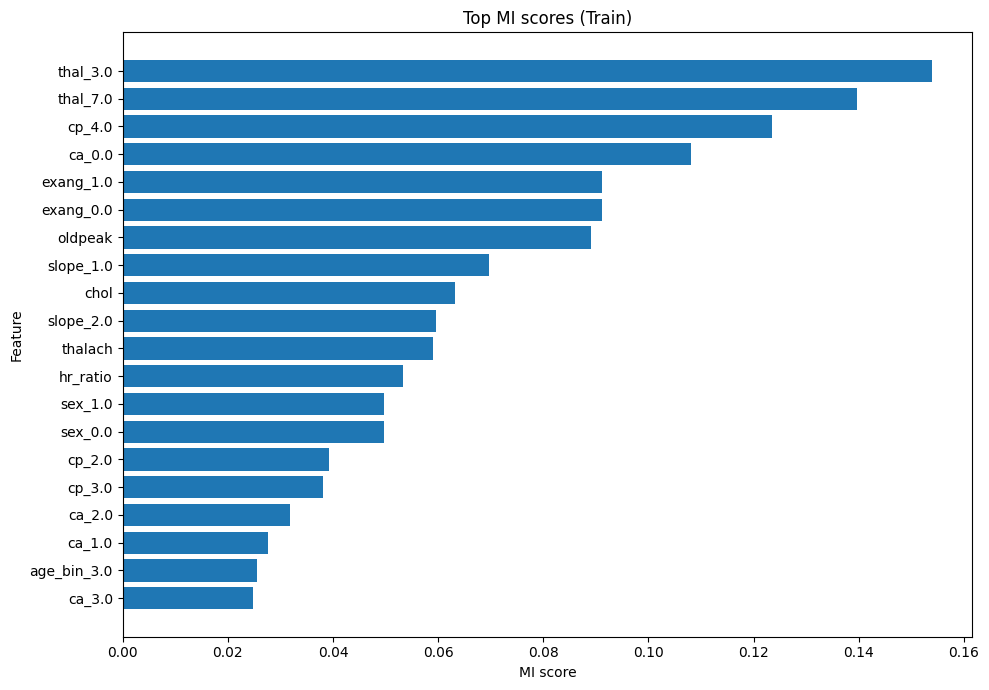

Selected TOP-K engineered features (K = RAW features): 13


0      thal_3.0
1      thal_7.0
2        cp_4.0
3        ca_0.0
4     exang_1.0
5     exang_0.0
6       oldpeak
7     slope_1.0
8          chol
9     slope_2.0
10      thalach
11     hr_ratio
12      sex_1.0
Name: fe_topk_features, dtype: object

Saved FE splits. K (FE features) = 13


In [38]:
def add_new_features(Xdf):
    Xdf = Xdf.copy()
    if set(['chol','age']).issubset(Xdf.columns):
        Xdf['chol_per_age'] = Xdf['chol'] / Xdf['age']
    if set(['trestbps','age']).issubset(Xdf.columns):
        Xdf['bps_per_age'] = Xdf['trestbps'] / Xdf['age']
    if set(['thalach','age']).issubset(Xdf.columns):
        Xdf['hr_ratio'] = Xdf['thalach'] / Xdf['age']
    if 'age' in Xdf.columns:
        Xdf['age_bin'] = pd.cut(Xdf['age'], bins=5, labels=False).astype('category')
    return Xdf

generated_cats = ['age_bin']
generated_nums = ['chol_per_age','bps_per_age','hr_ratio']
all_cats = categorical_cols + generated_cats
all_nums = numeric_cols + generated_nums

cat_proc = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
num_proc = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

preprocess = ColumnTransformer([
    ("num", num_proc, all_nums),
    ("cat", cat_proc, all_cats)
], verbose_feature_names_out=False).set_output(transform="pandas")

feature_adder = FunctionTransformer(add_new_features, validate=False)

fe_pipeline = Pipeline([
    ("add", feature_adder),
    ("preprocess", preprocess),
    ("var_filter", VarianceThreshold())
]).set_output(transform="pandas")

Xt_tr_np = fe_pipeline.fit_transform(X_train, y_train)
Xt_va_np = fe_pipeline.transform(X_val)
Xt_te_np = fe_pipeline.transform(X_test)

ohe = fe_pipeline.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot']
cat_names = []
for col, cats in zip(all_cats, ohe.categories_):
    for c in cats:
        cat_names.append(f"{col}_{c}")
pre_names = list(all_nums) + cat_names
mask = fe_pipeline.named_steps['var_filter'].get_support()
eng_cols = [name for name, keep in zip(pre_names, mask) if keep]

Xt_tr = pd.DataFrame(Xt_tr_np, columns=eng_cols, index=X_train.index)
Xt_va = pd.DataFrame(Xt_va_np, columns=eng_cols, index=X_val.index)
Xt_te = pd.DataFrame(Xt_te_np, columns=eng_cols, index=X_test.index)

is_discrete = np.array([col.startswith('age_bin_') or any(col.startswith(pfx) for pfx in ['sex_','cp_','fbs_','restecg_','exang_','slope_','ca_','thal_']) for col in Xt_tr.columns], dtype=bool)
mi_scores = mutual_info_classif(Xt_tr.values, y_train.values, discrete_features=is_discrete, random_state=42)
mi_series = pd.Series(mi_scores, index=Xt_tr.columns).sort_values(ascending=False)

# Visualize Top MI
topN = int(min(20, len(mi_series)))
top_mi = mi_series.head(topN).iloc[::-1]
plt.figure(figsize=(10, max(6, 0.35*topN)))
plt.barh(top_mi.index, top_mi.values)
plt.title('Top MI scores (Train)')
plt.xlabel('MI score'); plt.ylabel('Feature')
plt.tight_layout(); plt.show()

K = len([c for c in raw.columns if c != 'target'])
topk_cols = list(mi_series.head(K).index)
print("Selected TOP-K engineered features (K = RAW features):", K)
display(pd.Series(topk_cols, name="fe_topk_features").reset_index(drop=True))

fe_tr = Xt_tr[topk_cols].copy()
fe_tr['target'] = y_train.values
fe_va = Xt_va[topk_cols].copy()
fe_va['target'] = y_val.values
fe_te = Xt_te[topk_cols].copy()
fe_te['target'] = y_test.values

out_dir = Path('splits')
out_dir.mkdir(parents=True, exist_ok=True)
fe_tr.to_csv(out_dir / 'fe_train.csv', index=False)
fe_va.to_csv(out_dir / 'fe_val.csv', index=False)
fe_te.to_csv(out_dir / 'fe_test.csv', index=False)

print("Saved FE splits. K (FE features) =", K)

In [30]:
display(fe_tr.head())
display(fe_tr.isna().sum())

,thal_3.0,thal_7.0,cp_4.0,ca_0.0,exang_1.0,exang_0.0,oldpeak,slope_1.0,chol,slope_2.0,thalach,hr_ratio,sex_1.0,target
180,0.0,1.0,1.0,1.0,0.0,1.0,-0.445445,0.0,0.458139,1.0,0.708371,0.726265,1.0,1
208,1.0,0.0,0.0,1.0,0.0,1.0,-0.891627,1.0,0.230598,0.0,0.222495,-0.054469,1.0,0
167,1.0,0.0,0.0,0.0,1.0,0.0,-0.891627,1.0,0.723605,0.0,0.399178,0.099522,0.0,0
105,0.0,1.0,0.0,1.0,0.0,1.0,-0.891627,1.0,1.121803,0.0,0.266666,0.031766,1.0,0
297,0.0,1.0,1.0,1.0,1.0,0.0,-0.713154,0.0,-0.167601,1.0,-1.190962,-0.859761,0.0,1


thal_3.0     0
thal_7.0     0
cp_4.0       0
ca_0.0       0
exang_1.0    0
exang_0.0    0
oldpeak      0
slope_1.0    0
chol         0
slope_2.0    0
thalach      0
hr_ratio     0
sex_1.0      0
target       0
dtype: int64

In [ ]:
# zip folder
# !zip -r dataset.zip splits